In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential

Using TensorFlow backend.


# Data Loading

In [0]:
data = pd.read_csv('/content/drive/My Drive/3_SPAM detection/a.csv')
data = data[['v1','v2']] # v1-Classlabel,v2-Text

In [4]:
print('No of DataPoint',data.shape[0])
print('\nNo of dataPoint for each class\n',data['v1'].value_counts())
total_datapoint = data.shape[0]
ham_datapoint = data[data['v1'] == 'ham'].shape[0]
spam_datapoint = data[data['v1'] == 'spam'].shape[0]
print('\nPercentage of ham datapoint is : ',ham_datapoint/total_datapoint * 100)
print('Percentage of spam datapoint is : ',spam_datapoint/total_datapoint * 100)


No of DataPoint 5572

No of dataPoint for each class
 ham     4825
spam     747
Name: v1, dtype: int64

Percentage of ham datapoint is :  86.59368269921033
Percentage of spam datapoint is :  13.406317300789663


In [5]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Basic EDA of Data

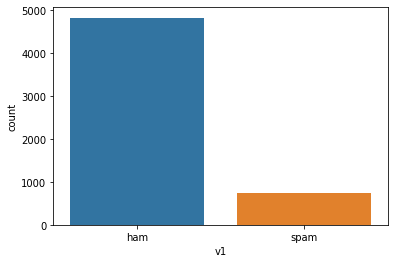

In [6]:
# Count plot according classs label
sns.countplot(data.v1)

1. There are large no of ham text as compared  to spam text which leads to imbalance data sets.

In [0]:
# Count no od word in text
def text_length(row):
    return len(row.split(" "))
data['text_length'] = data['v2'].apply(lambda row : text_length(row))

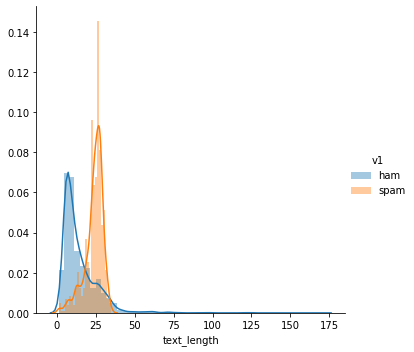

In [8]:
sns.FacetGrid(data,hue='v1',height=5).map(sns.distplot,'text_length').add_legend()

1. Spam text with large text length as compare to ham

In [9]:
#count punctuation percent in text
print('Punctuation symbole are : ',string.punctuation)
def punc_percent(row):
    c = sum([1 for char in row if char in string.punctuation])
    return (round(c/len(row),3)*100)
data['punc%'] = data['v2'].apply(lambda x : punc_percent(x))

Punctuation symbole are :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


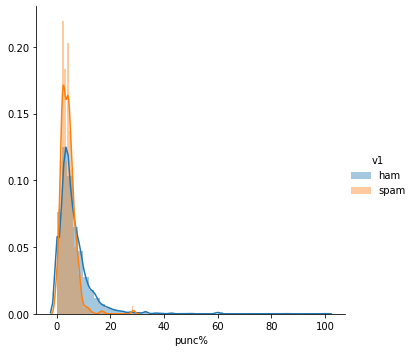

In [10]:
sns.FacetGrid(data,hue='v1',height=5).map(sns.distplot,'punc%').add_legend()

1. punc% for spam text and ham text almost same but for some ham text punc% large compare to ham text
2. PDF of spam text is high means most of spam text puc% are at 4-6

# Data Preprocessing

 <h4><b>1.1 Remove punctuation

In [0]:
def remove_punctu(row):
    row_nonpunct = "".join([char for char in row if char not in string.punctuation])
    return row_nonpunct

<h4><b>1.2 Decontracted

In [0]:
import re
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

<h4><b>1.3 Remove word with number

In [0]:
def remove_numword(row):
    return re.sub("\S*\d\S*", "", row).strip()

<h4><b>1.4 Remove spacial character

In [0]:
def remove_special_char(row):
    return re.sub('[^A-Za-z0-9]+', ' ', row)

<h4><b>1.5 Remove stop word

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)
def remove_stopword(row):
    return(" ".join([char for char in row.split(" ") if char not in stopword]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'a

<h1><b>Preprocessing

In [0]:
preprocessed_reviews = []
for sentance in data['v2'].values:
    sentance = remove_punctu(sentance)
    sentance = decontracted(sentance)
    sentance = remove_numword(sentance)
    sentance = remove_special_char(sentance)
    sentance = remove_stopword(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_reviews.append(sentance.strip())

In [0]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

# Word2Vec model and prepare data for training and test

In [18]:
# min_count = 5 considers only words that occured atleast 5 times
# size=100 means it use top 100 words which are occured atleast 5 time
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=100, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1679
sample words  ['go', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'cine', 'got', 'wat', 'ok', 'lar', 'joking', 'wif', 'u', 'free', 'entry', 'wkly', 'comp', 'win', 'cup', 'final', 'may', 'text', 'receive', 'txt', 'apply', 'dun', 'say', 'early', 'c', 'already', 'nah', 'i', 'dont', 'think', 'goes', 'usf', 'around', 'though', 'freemsg', 'hey', 'darling', 'weeks', 'word', 'back', 'id']


tfidf = tf * idf
1. tf = no of time word w_i in text t_j / total word in t_j
2. idf = log(total text / no of text which contains word w_i)

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = (sent.count(word)/len(sent))*dictionary[word]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [21]:
feature = np.array(tfidf_sent_vectors)
print(feature.shape)
feature=np.vstack((feature.T,np.array(data['text_length']).T)).T
feature=np.vstack((feature.T,np.array(data['punc%']).T)).T
print(feature.shape)

(5572, 100)
(5572, 102)


In [22]:
x = feature
y = data['v1']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
print('No of train data pioint : ',x_train.shape)
print('No of test data pioint : ',x_test.shape)

print('\nNo of ham and spam datapoint in train data : \n',y_train.value_counts())
print('\nNo of ham and spam datapoint in test data :  \n',y_test.value_counts())


No of train data pioint :  (4457, 102)
No of test data pioint :  (1115, 102)

No of ham and spam datapoint in train data : 
 ham     3844
spam     613
Name: v1, dtype: int64

No of ham and spam datapoint in test data :  
 ham     981
spam    134
Name: v1, dtype: int64


# ML : Logistic Regression

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Score :  0.9542600896860987
[[960  21]
 [ 30 104]]


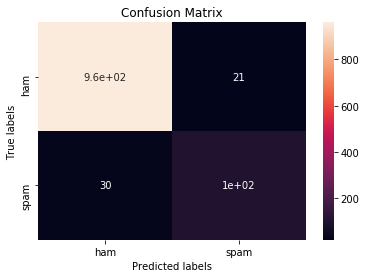

In [24]:
from sklearn.linear_model import LogisticRegression
tuned_parameters =  [{'C': [10**-4, 10**-2, 10**0, 10**4]}]
model = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, scoring = 'accuracy', cv=10)
model.fit(x_train, y_train)
print(model.best_estimator_)
print('Score : ',model.score(x_test, y_test))
y_pred = model.predict(x_test)
print(confusion_matrix(y_test,y_pred,labels=['ham','spam']))
cm=confusion_matrix(y_test,y_pred,labels=['ham','spam'])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ham', 'spam']); 
ax.yaxis.set_ticklabels(['ham', 'spam']);

model perform best on ham as compare to spam duto lake of less no data point of spam text

# ML : Random Forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=45,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Score :  0.9721973094170404
[[976   5]
 [ 26 108]]


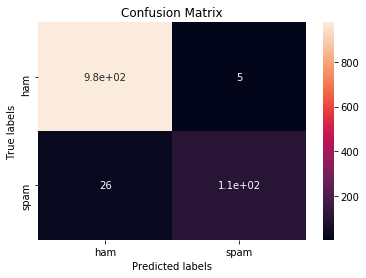

In [26]:
params = {'n_estimators':[20,45,80,100],'max_depth':[10,15,20]}
clf = RandomForestClassifier()
model = GridSearchCV(clf,params)
history=model.fit(x_train,y_train)
print(model.best_estimator_)
print('Score : ',model.score(x_test, y_test))
y_pred = model.predict(x_test)
print(confusion_matrix(y_test,y_pred,labels=['ham','spam']))
cm=confusion_matrix(y_test,y_pred,labels=['ham','spam'])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ham', 'spam']); 
ax.yaxis.set_ticklabels(['ham', 'spam']);

Random forest perform best compare to Logistic Regression

# Deep Learning - LSTM

In [0]:
from sklearn.preprocessing import LabelEncoder # to encode class label name in 0 to no of class

In [0]:
text = data['v2']
label = data['v1']
le = LabelEncoder()
label = le.fit_transform(label)
label = label.reshape(-1,1)

Here we train data based on batch size and each text are of different length so we need to make all text of same lenth because all text in batch should be same laength so we need to do some padding sequence

In [29]:
max_words = 1000  # like vocabulary size
max_len = 150
tok = Tokenizer(num_words=max_words) # num_word define number of word to be consider based on word frequency
                                     # so it consider mostly occured 1000 words and create dictionary of word 
tok.fit_on_texts(text) # takes data courpus and create dictionary of word 
sequences = tok.texts_to_sequences(text) # now it replace each word with dictionary word index
print(sequences[0:5])
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #it convert each sms of same length because here each sms length are different
print(sequences_matrix[0])  
X_train,X_test,Y_train,Y_test = train_test_split(sequences_matrix,label,test_size=0.15)


[[50, 468, 835, 749, 656, 65, 8, 91, 120, 350, 147, 67, 58, 144], [46, 337, 469, 6], [47, 485, 8, 19, 4, 792, 893, 2, 177, 657, 265, 71, 2, 2, 338, 485, 553, 950, 73, 388, 181, 658, 389], [6, 243, 152, 23, 379, 6, 140, 154, 57, 152], [1, 99, 108, 69, 486, 2, 951, 69, 217, 112, 470]]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  50 468 835 749 656  65   8  91
 120 350 147  67  58 144]


In [30]:
batch_size=512
model = Sequential()
model.add(Embedding(max_words,60,input_length=max_len)) # 60 define output dim
                                                      # maxwords define the largest integer (i.e. word index) in the input should be
                                                      # no larger than 999 (vocabulary size)
model.add(LSTM(100))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=512,epochs=10,validation_split=0.2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3788 samples, validate on 948 samples
Epoch 1/10





3788/3788 [==============================] - 12s 3ms/step - loss: 0.5515 - acc: 0.8115 - val_loss: 0.3491 - val_acc: 0.8597
Epoch 2/10
3788/3788 [==============================] - 2s 490us/step - loss: 0.3073 - acc: 0.8638 - val_loss: 0.2530 - val_acc: 0.8608
Epoch 3/10
3788/3788 [==============================] - 2s 487us/step - loss: 0.2045 - acc: 0.9248 - val_loss: 0.1661 - val_acc: 0.9483
Epoch 4/10
3788/3788 [==============================] - 2s 493us/step - loss: 0.1200 - acc: 0.9720 - val_loss: 0.1127 - val_acc: 0.9673
Epoch 5/10
3788/3788 [==============================] - 2s 487us/step - loss: 0.0690 - acc: 0.9831 - val_loss: 0.0829 - val_acc: 0.9800
Epoch 6/10
3788/3788 [=============================

836/836 [==============================] - 2s 2ms/step
[0.0314091853460444, 0.9940191387559809]
[[739   1]
 [  4  92]]


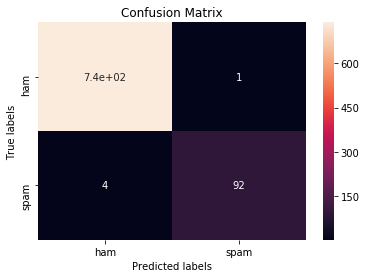

In [31]:
print(model.evaluate(X_test,Y_test))
Y_pred = model.predict_classes(X_test)
print(confusion_matrix(Y_test,Y_pred))
cm=confusion_matrix(Y_test,Y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ham', 'spam']); 
ax.yaxis.set_ticklabels(['ham', 'spam']);

LSTM perform best compare to Random Forest

# Conclusion
1. LogisticRegression gives 96.41% accuracy on test data
2. RandomForest gives 97.57% accuracy on test data
3. LSTM deep learning gives 99.40% accuracy on test data